In [1]:
import sys
sys.path.append('/home/martin/tesis/inverse_filter_deepdereverb/')
from model.net import if_autoencoder
from data.funciones import *
from notebook_utils import get_audio_list

RIR_PATH = '/home/martin/datasets/rir/C4DM/classroom'
SPEECH_PATH = '/home/martin/datasets/speech/LibriSpeech'
SAVE_PATH='/home/martin/tesis/inverse_filter_deepdereverb/npy_data/'
WEIGHTS = '/home/martin/tesis/inverse_filter_deepdereverb/model/ckpts/weights.hdf5'
Q_e = 32
LM = 5
Pd = 9

In [2]:
rir_list = get_audio_list(RIR_PATH)
speech_list = get_audio_list(SPEECH_PATH)

In [3]:
modelo = if_autoencoder(LM, Pd)
modelo.load_weights(WEIGHTS)

In [4]:
def load_npy(path):
    input_A = np.empty((1, 256, 5, 1))                                                                                
    input_B = np.empty((1, 256, 9, 1))                                                                                
    output = np.empty((1, 256, 1))                                                                                    
    saved_array = np.empty((256,15))                                                                                       
    LM = 5                                                                                                                          
    Pd = 9                                                                                                                          
    # Generate data                                                                                                                 

    saved_array = np.load(path)                                                                         
    input_A = saved_array[:, :LM].reshape(1,256, LM,1)                                                                         
    input_B = saved_array[:,LM:LM+Pd].reshape(1,256, Pd, 1)                                                                    
    output = saved_array[:, -1:].reshape(1,256,1)                                                                              

    return [input_A, input_B], output

In [5]:
[input_A, input_B], output = load_npy('../data/npy_data/10.npy')

In [6]:
dereverb = modelo.predict([input_A, input_B])

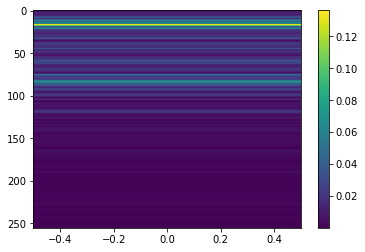

In [7]:
plt.imshow(output.reshape(256,-1), aspect='auto')
plt.colorbar()

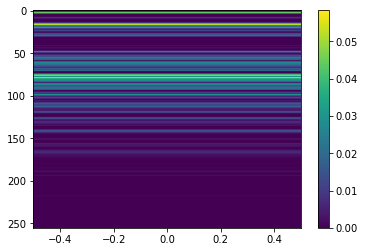

In [8]:
plt.imshow(dereverb.reshape(256,-1), aspect='auto')
plt.colorbar()

# Para un audio entero

In [42]:
from scipy.signal import fftconvolve
from IPython.display import Audio

In [12]:
reverb_spec, early_reverb_spec = generate_specs(rir_list[0], speech_list[0], Q_e)

In [27]:
n_frames = np.arange(reverb_spec.shape[1])                                                                                          
valid_frames = n_frames[Pd-1:int(-((LM-1)/2)-1)]                                                                                    

inputs = []
outputs = []
for l in valid_frames:                                                                                                              
    input_A = reverb_spec[:, int(l-((LM-1)/2)):int(l+((LM-1)/2)+1)]                                                                 
    input_A = normalise(np.log(input_A**2+EPS))                                                                                     

    input_B = reverb_spec[:, l-Pd+1:l+1]                                                                                            

    output = early_reverb_spec[:, l]
    
    inputs.append([input_A, input_B])
    outputs.append(output.reshape(256,1))


In [72]:
#concatenate frames
clean_conc = np.concatenate(librosa.amplitude_to_db(outputs), axis=1)

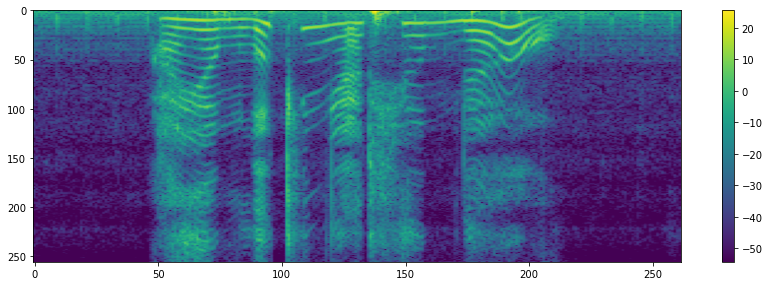

In [73]:
plt.imshow(clean_conc, aspect='auto')
plt.colorbar()
plt.subplots_adjust(right=2, top=1)

In [66]:
audio_clean = librosa.griffinlim(clean_conc, n_iter=500, hop_length = 160, win_length=400, window=scipy.signal.windows.hamming)
Audio(audio_clean, rate=16000)

In [58]:
dereverbs = []
for i in inputs:
    in_a, in_b = i
    dereverb = modelo.predict([in_a.reshape(1,256,LM,1), in_b.reshape(1,256,Pd,1)])
    dereverbs.append(dereverb.reshape(256,1))

In [63]:
dereverb_conc = np.concatenate(dereverbs, axis=1)

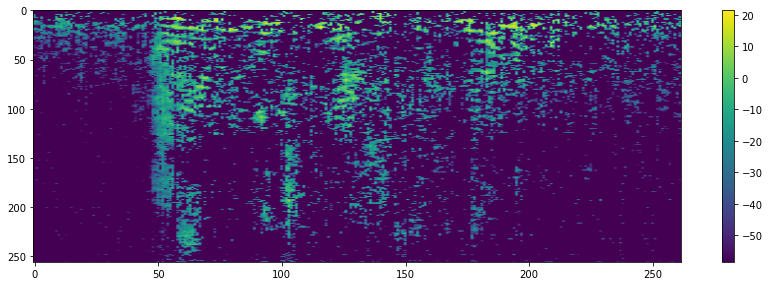

In [71]:
plt.imshow(librosa.amplitude_to_db(dereverb_conc), aspect='auto')
plt.colorbar()
plt.subplots_adjust(right=2, top=1)

In [67]:
audio_dereverb = librosa.griffinlim(dereverb_conc, n_iter=500, hop_length = 160, win_length=400, window=scipy.signal.windows.hamming)
Audio(audio_dereverb, rate=16000)